# Hexagonal Grid Positioning

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Interactive display
import ipywidgets as widgets

from itertools import product

Let's implement the generalized Hexagonal Grid Function using formulas from the [Hexagonal Oscillatory Interference](./Hexagonal%20Oscillatory%20Interference.ipynb) Model. Note that we use one parameter for scaling for simplification purposes:

In [2]:
def HexagonalGrid(X, Y, *, x_shift=0, y_shift=0, scaling=1, rotation=0):
    f_1 = np.cos(2 * np.pi * (scaling * (X - x_shift) * np.cos(rotation) + scaling * (Y - y_shift) * np.sin(rotation)))
    f_2 = np.cos(2 * np.pi * (scaling * (X - x_shift) * np.cos(rotation + np.pi/3) + scaling * (Y - y_shift) * np.sin(rotation + np.pi/3)))
    f_3 = np.cos(2 * np.pi * (scaling * (X - x_shift) * np.cos(rotation - np.pi/3) + scaling * (Y - y_shift) * np.sin(rotation - np.pi/3)))
    return (f_1 + f_2 + f_3 + 1.5) / 4.5

We already can do some positioning. Here are neuron firing rates for different coordinates from the grid with default parameters:

In [3]:
DefaultGrid = lambda x, y: HexagonalGrid(x, y)

for x, y in ((0, 0), (0, 1), (1, 0), (1, 1), (2, 1)):
    print(f"x = {x}, y = {y}, Activation: {DefaultGrid(x, y)}")

x = 0, y = 0, Activation: 1.0
x = 0, y = 1, Activation: 0.8516137438233456
x = 1, y = 0, Activation: 0.1111111111111111
x = 1, y = 1, Activation: 0.2594973672877655
x = 2, y = 1, Activation: 0.8516137438233455


We can see the ambiguity: the activation for the point $\left(0, 1\right)$ and $\left(2, 1\right)$ is almost the same! Maybe we could solve this by adding additional neurons with different rotation, scale and shift?

In [4]:
neurons = [
    lambda x, y: HexagonalGrid(x, y, x_shift=0, y_shift=0, scaling=1, rotation=0),
    lambda x, y: HexagonalGrid(x, y, x_shift=0.5, y_shift=0.5, scaling=0.2, rotation=np.pi/6),
    lambda x, y: HexagonalGrid(x, y, x_shift=0, y_shift=0, scaling=2, rotation=-np.pi/18),
    lambda x, y: HexagonalGrid(x, y, x_shift=-0.5, y_shift=-0.5, scaling=0.5, rotation=np.pi/12),
    lambda x, y: HexagonalGrid(x, y, x_shift=0, y_shift=0.5, scaling=1.5, rotation=np.pi/9),
]

NeuronVector = lambda x, y: np.array([neuron(x, y) for neuron in neurons])

for x, y in ((0, 0), (0, 1), (1, 0), (1, 1), (2, 1)):
    print(f"x = {x}, y = {y}, Activation Vector: {NeuronVector(x, y)}")

x = 0, y = 0, Activation Vector: [1.         0.87475853 1.         0.40189287 0.0875266 ]
x = 0, y = 1, Activation Vector: [0.85161374 0.87475853 0.14947061 0.04857189 0.0875266 ]
x = 1, y = 0, Activation Vector: [0.11111111 0.87475853 0.41277511 0.04857189 0.08944548]
x = 1, y = 1, Activation Vector: [0.25949737 0.87475853 0.34005225 0.94307019 0.33296384]
x = 2, y = 1, Activation Vector: [0.85161374 0.48708379 0.10259025 0.2299166  0.60721996]


Wee can see that the vectors values differ for different points in space. It allows us to infer the coordinate from the whole vector of activation.

Let's make an visual demo on how different grids become more or less active depending on the point in space. Consider an area of the 2-dimensional plane:

In [5]:
delta = 0.01
x_min, x_max = -5, 5
y_min, y_max = -5, 5

x = np.arange(x_min, x_max, delta)
y = np.arange(y_min, y_max, delta)

X, Y = np.meshgrid(x, y)

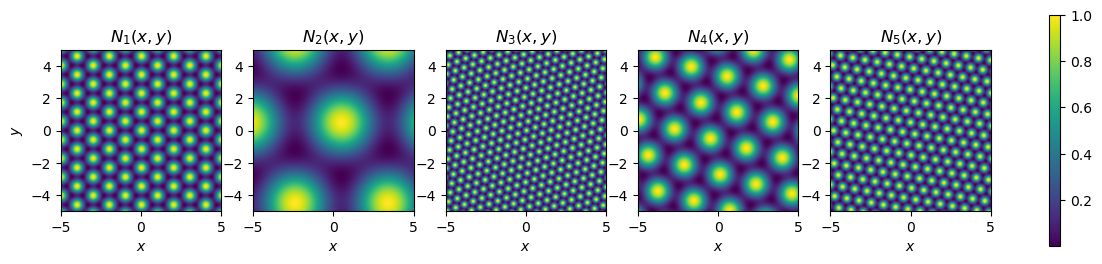

In [6]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3))

for i, neuron in enumerate(neurons):
    im = axes[i].imshow(neuron(X, Y), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[i].set_title(r"$N_{}\left(x, y\right)$".format(i + 1))
    axes[i].set_xlabel(r"$x$")
    if i == 0:
        axes[i].set_ylabel(r"$y$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

For a position approximation let's use a weighted sum of all the grids with each weight being equal to the activation value. Then the position can be determinet as $\argmax$ of a such sum:

In [7]:
def PositionApproximation(X, Y, x, y, neurons):
    weights = np.array([neuron(x, y) for neuron in neurons])
    return sum(weight * neuron(X, Y) for weight, neuron in zip(weights, neurons)) / len(neurons)

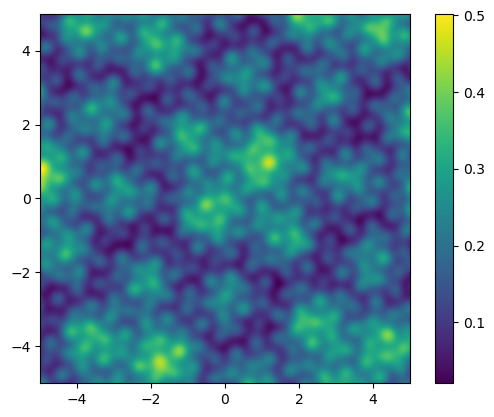

In [8]:
plt.imshow(PositionApproximation(X, Y, 1, 1, neurons), origin="lower", extent=[x_min, x_max, y_min, y_max])
plt.colorbar();

It still looks a bit ambiguous! But we clearly see a local maximum near the desired point $\left(1, 1\right)$.

So, our goal during the optimization process would be to minimize the ambiguity. Before this, let's do a simple interactive example:

In [9]:
@widgets.interact(
    x=widgets.FloatSlider(0, min=-5.0, max=5.0),
    y=widgets.FloatSlider(0, min=-5.0, max=5.0),
)

def plot_position_estimate(x, y):
    plt.imshow(PositionApproximation(X, Y, x, y, neurons), origin="lower", extent=[x_min, x_max, y_min, y_max])
    plt.plot(x, y, marker="x", markersize=20, markeredgecolor="red")
    plt.colorbar()
    plt.clim(0, 1)

interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

We see that there are a lot of points where almost no activations happen. The representation is by its nature ambiguous and incomplete. Our next goal will be to make it more precise.